# ERA star

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.erastar as eras

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=10, processes=10) # a tester
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.186:8787/status,
Dashboard: http://10.148.0.186:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.186:48240,Workers: 0
Dashboard: http://10.148.0.186:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


_________
## Load data

nc_files = box.load_collocalisations(2018, drifter='gps')
#ds = box.build_dataset(nc_files, 10)
ds = box.build_dataset(nc_files[10], chunks=dict(obs=100))
ds

In [3]:
l = cstes.labels[3]
ds_data = xr.open_zarr(cstes.zarr_dir+'/'+l+'.zarr').chunk({'obs':25, 'alti_time':-1, 'site_obs':-1}).persist()

In [6]:
era_star_dir = "/home/datawork-cersat-public/provider/woc/products/theme1/ocean_winds/woc-l4-se-erastar-h/v2.0/"

---

# load erastar

### Load erastar data for a single collocation

In [6]:
def load_eras(t, dt=None, suffix="es_", to_360 = False, rkwargs=None, **kwargs):
    """ Extract ERA star data
    Ref ...
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    """
    #TIME
    t = pd.to_datetime(t)
    if dt is not None:
        t =[t+pd.Timedelta(np.timedelta64(_dt, "h")) for _dt in range(*dt)]
    else:
        t = [t]
    print(t)
    if rkwargs is None:
        rkwargs={}
    #LOAD    
    D = []
    for _t in t:

        _rpath = f"{_t.year}/{_t.dayofyear:03d}/{_t.year}{_t.month:02d}{_t.day:02d}{_t.hour:02d}*.nc"
        files = glob(os.path.join(era_star_dir, _rpath))
            
        if to_360 : # turn erastar to 0-360° if needed
            _ds = (xr.load_dataset(files[0], **rkwargs)
                   #.sel(**kwargs) #in case 180 limit
                      )
            assert all(_ds.lon<180), 'error : era_star in 0-360° lon coordinates' # verify -180-180° representation for lon coordinates
            _ds = _ds.assign_coords(lon=cstes.lon_180_to_360(_ds.lon))
            _ds = _ds.sortby('lon')
            _ds = _ds.sel(**kwargs) #select data around the colocalisation
            
        else :
            _ds = (xr.load_dataset(files[0], **rkwargs).sel(**kwargs))
                       
            assert all(_ds.lon<180), 'error : era_star in 0-360° lon coordinates' # verify -180-180° representation for lon coordinates
    
        D.append(_ds)
    ds = xr.concat(D, dim="time")
    ds = ds.rename(lon=suffix +"lon", lat=suffix +"lat", time=suffix +"time")

    return ds

### Interpolate erastar

In [7]:
def get_eras_one_obs(ds_obs, dt=(-12,13), only_matchup_time = True):
    """ load erastar for one collocation """
    dl = 0.125
    assert (ds_obs['box_lon']=<180).all(), 'error : ds_obs in 0-360° lon coordinates'
    
    # -180-180 longitude problem
    limite_lon = (ds_obs.drifter_lon>179).any() or (ds_obs.drifter_lon<-179).any() or (ds_obs.box_lon>179).any() or (ds_obs.box_lon<-179).any()
    
    if limite_lon :
        box_lon = cstes.lon_180_to_360(ds_obs.box_lon)
        drifter_lon = cstes.lon_180_to_360(ds_obs.drifter_lon)
        _alti_lon = cstes.lon_180_to_360(ds_obs.alti_lon.isel(alti_time=10))# only matchup

    else : 
        box_lon = ds_obs['box_lon']  
        drifter_lon = ds_obs['drifter_lon'] 
        _alti_lon = ds_obs['alti_lon'].isel(alti_time=10)# only matchup
        
    # matchup site
    site_matchup_indice = int(ds_obs.__site_matchup_indice.values)
    _drifter_lon = drifter_lon.isel(site_obs = site_matchup_indice).values
    _drifter_lat = ds_obs.drifter_lat.isel(site_obs = site_matchup_indice).values
    _drifter_time = ds_obs.drifter_time.isel(site_obs = site_matchup_indice).values
                                         
    #select eras only over the box/drifter trajectory
    lon_min = min(box_lon.min(), drifter_lon.min())
    lon_max = max(box_lon.max(), drifter_lon.max())
    lat_min = min(ds_obs.box_lat.min(), ds_obs.drifter_lat.min())
    lat_max = max(ds_obs.box_lat.max(), ds_obs.drifter_lat.max())
    
    
    
    
    # load data
    _drop = ['es_u10s','es_v10s','e5_u10s','e5_v10s','count','quality_flag']
    try : 
        ds_eras = load_eras(ds_obs.time.values, dt, to_360 = limite_lon,
                          rkwargs={'drop_variables':_drop}, 
                            lon=np.arange(lon_min-dl,lon_max+2*dl, dl), lat=np.arange(lat_min-dl,lat_max+2*dl, dl), method='nearest', tolerance=dl)
    except : 
        assert False, ds_obs.__site_id.values
    print(list(ds_eras.es_time.values))

    # interplate over the trajectoire
    #try : 
    ds_traj = ds_eras.interp(es_lon =drifter_lon, es_lat = ds_obs.drifter_lat, es_time = ds_obs.drifter_time).rename({v: "traj_"+v for v in ds_eras}).drop(['drifter_lon', 'drifter_lat','es_time','es_lon','es_lat','lat','lon','time'])
    #except:
        #assert False, (ds_obs.__site_id.values, ds_obs.drifter_time.values, drifter_lon.values)
        
    #interpolate on the box
    if only_matchup_time : 
        ds_box = ds_eras.interp(es_time = _drifter_time, es_lon = box_lon, es_lat = ds_obs.box_lat).rename({v: "box_matchup_"+v for v in ds_eras}).drop(['es_lon','es_lat','es_time','lat','lon','time'])
    else : 
        ds_box = ds_eras.interp( es_lon = box_lon, es_lat = ds_obs.box_lat).rename({v: "box_matchup_"+v for v in ds_eras}).drop(['es_lon','es_lat','lat','lon','time'])
        
    # interpolate at drifter matchup position, for all drifter times
    ds_drifter = ds_eras.interp(es_lon = _drifter_lon, es_lat = _drifter_lat).drop(['es_lon', 'es_lat']).rename({v: "drifter_matchup_"+v for v in ds_eras})
    
    # at alti matchup
    ds_alti = ds_eras.interp(es_time = ds_obs.alti_time_.isel(alti_time=10), es_lon =_alti_lon, es_lat = ds_obs.alti_lat.isel(alti_time=10))
    ds_alti = ds_alti.drop(list(ds_alti.coords.keys())).rename({v: "alti_matchup_"+v for v in ds_eras})
    
    # convert to dataset and massage in order to concatenate properly in get_aviso
    ds = (xr.merge([ds_traj, ds_box, ds_drifter, ds_alti])).reset_index("es_time").reset_coords(["drifter_time", "drifter_x", "drifter_y", 'es_time_'])
    
    ds['time']=ds_obs.time.drop(['lon', 'lat'])
    
    return ds, ds_eras


#def _concat_eras(ds, dt=(-1,2), only_matchup_time=True):
#""" Load erastar data for multiple collocations and concatenate """
#    return xr.concat([get_eras_one_obs(ds.sel(obs=o), dt, only_matchup_time) for o in ds.obs], 'obs')

def _concat_eras(ds, dt, only_matchup_time=True):
    """ Load erastar data for multiple collocations and concatenate """
    try :
        _ds=xr.concat([get_eras_one_obs(ds.sel(obs=o), dt, only_matchup_time) for o in ds.obs], 'obs')
    except:
        assert False, ds.time.values
    return _ds

def compute_eras(ds, dt=(-12,13), only_matchup_time = True):
    """
    https://xarray.pydata.org/en/stable/user-guide/dask.html
    Parameters
    ----------
    ds: xr.Dataset
        Input collocation dataset
    dt: tuple
        Time offsets compared to the collocation, e.g. if collocation
        is at time t and dt=(-5,5), erastar data will be interpolated on 
        the interval (t-5 days, t+5 days) with an hour step
        Default is (-1,2)
    only_matchup_time : bool
                        if True return stress on the box only for the drifter matchup time
                        if False return it for all erastar time over the dt period

    Return
    ------
    ds: xr.Dataset
        Dataset containing relevant aviso data

    """
    # build template
    template = _concat_eras(ds.isel(obs=slice(0,2)), dt=dt, only_matchup_time=only_matchup_time)
    
    # broad cast along obs dimension
    template, _ = xr.broadcast(template.isel(obs=0).chunk(), 
                               ds,
                               exclude=[ "es_time", "alti_time", "alti_time_mid", "site_obs", "box_x", "box_y",],
                              )
    
    # massage further and unify chunks
    template = (xr.merge([template, ds.drop(["lon", "lat", "time","drifter_lon","drifter_lat","drifter_x","drifter_y", "drifter_time",])])
             .unify_chunks()[list(template.keys())])

    # dimension order is not consistent with that of exiting from map_blocks for some reason
    dims = ["obs", "es_time", "box_y", "box_x", "site_obs"]    
    
    template = template.transpose(*dims)#.set_coords(["drifter_time", "drifter_x","drifter_y"])
   
    # actually perform the calculation
    ds_eras = xr.map_blocks(_concat_eras, ds, kwargs=dict(dt=dt, only_matchup_time=only_matchup_time), template=template)
    ds_eras = ds_eras.set_coords(["time", 'es_time_'])# coordinate for obs dimension

    return ds_eras


## Test template

In [12]:
dt = (-1,2)
only_matchup_time = True
# build template
template0 = _concat_eras(ds_data.isel(obs=slice(0,5)), dt=dt, only_matchup_time=only_matchup_time)
    
# broad cast along obs dimension
template1, _ = xr.broadcast(template0.isel(obs=0).chunk(), 
                               ds_data,
                               exclude=[ "es_time", "alti_time", "alti_time_mid", "site_obs", "box_x", "box_y",],
                              )

In [43]:
template0

<xarray.Dataset>
Dimensions:                  (obs: 5, site_obs: 1489, box_y: 40, box_x: 80,
                              es_time: 73)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
Dimensions without coordinates: obs, site_obs, es_time
Data variables: (12/21)
    traj_es_tauu             (obs, site_obs) float64 nan nan nan ... nan nan nan
    traj_es_tauv             (obs, site_obs) float64 nan nan nan ... nan nan nan
    traj_e5_tauu             (obs, site_obs) float64 nan nan nan ... nan nan nan
    traj_e5_tauv             (obs, site_obs) float64 nan nan nan ... nan nan nan
    drifter_time             (obs, site_obs) datetime64[ns] dask.array<chunksize=(1, 1489), meta=np.ndarray>
    drifter_x                (obs, site_obs) float64 dask.array<chunksize=(1, 1489), meta=np.ndarray>
    ...                       ...
    alti_matchup_es_tauu     (obs) float64 0.04719 0.1216 ... -0.169 0.01504
    alti_matchup_es_tauv     (obs) float64 -0.04039 0.2207 ... 0.1112 -0.01888
    alti_matchup_e5_tauu     (obs) float64 0.04807 0.1284 -0.04 -0.169 0.01504
    alti_matchup_e5_tauv     (obs) float64 -0.04585 0.2376 0.03 0.08071 -0.01
    es_time_                 (obs, es_time) datetime64[ns] 2016-11-30T04:00:0...
    time                     (obs) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    title:                       hourly stress equivalent model wind componen...
    summary:                     This data set contains the stress equivalent...
    id:                          WOC-L4-SE-ERAstar-H
    ...                          ...
    platform:                    Metop-A, Metop-B
    platform_type:               low earth orbit satellite, low earth orbit s...
    instrument:                  ASCAT, ASCAT
    instrument_type:             scatterometer, scatterometer
    band:                        C, C
    format_version:              WOС v1.0

In [38]:
template1

<xarray.Dataset>
Dimensions:                  (obs: 4054, site_obs: 1489, box_x: 80, box_y: 40,
                              es_time: 73)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
Dimensions without coordinates: obs, site_obs, es_time
Data variables: (12/21)
    traj_es_tauu             (obs, site_obs) float64 dask.array<chunksize=(4054, 1489), meta=np.ndarray>
    traj_es_tauv             (obs, site_obs) float64 dask.array<chunksize=(4054, 1489), meta=np.ndarray>
    traj_e5_tauu             (obs, site_obs) float64 dask.array<chunksize=(4054, 1489), meta=np.ndarray>
    traj_e5_tauv             (obs, site_obs) float64 dask.array<chunksize=(4054, 1489), meta=np.ndarray>
    drifter_time             (obs, site_obs) datetime64[ns] dask.array<chunksize=(4054, 1489), meta=np.ndarray>
    drifter_x                (obs, site_obs) float64 dask.array<chunksize=(4054, 1489), meta=np.ndarray>
    ...                       ...
    alti_matchup_es_tauu     (obs) float64 0.04719 0.04719 ... 0.04719 0.04719
    alti_matchup_es_tauv     (obs) float64 -0.04039 -0.04039 ... -0.04039
    alti_matchup_e5_tauu     (obs) float64 0.04807 0.04807 ... 0.04807 0.04807
    alti_matchup_e5_tauv     (obs) float64 -0.04585 -0.04585 ... -0.04585
    es_time_                 (obs, es_time) datetime64[ns] dask.array<chunksize=(4054, 73), meta=np.ndarray>
    time                     (obs) datetime64[ns] dask.array<chunksize=(4054,), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    title:                       hourly stress equivalent model wind componen...
    summary:                     This data set contains the stress equivalent...
    id:                          WOC-L4-SE-ERAstar-H
    ...                          ...
    platform:                    Metop-A, Metop-B
    platform_type:               low earth orbit satellite, low earth orbit s...
    instrument:                  ASCAT, ASCAT
    instrument_type:             scatterometer, scatterometer
    band:                        C, C
    format_version:              WOС v1.0

In [40]:
# massage further and unify chunks
_var = ['traj_es_tauu','traj_es_tauv','traj_e5_tauu','traj_e5_tauv',
        'box_matchup_es_tauu','box_matchup_es_tauv','box_matchup_e5_tauu','box_matchup_e5_tauv',
        'drifter_matchup_es_tauu','drifter_matchup_es_tauv','drifter_matchup_e5_tauu','drifter_matchup_e5_tauv',
        'alti_matchup_es_tauu','alti_matchup_es_tauv','alti_matchup_e5_tauu','alti_matchup_e5_tauv',
        'es_time_','time']
template2 = (xr.merge([template1, ds_data.drop(["lon", "lat", "time","drifter_lon","drifter_lat","drifter_x","drifter_y", "drifter_time",])])
             .unify_chunks()[list(template1.keys())])


In [41]:
template2

<xarray.Dataset>
Dimensions:                  (obs: 4054, site_obs: 1489, box_x: 80, box_y: 40,
                              es_time: 73)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
Dimensions without coordinates: obs, site_obs, es_time
Data variables: (12/21)
    traj_es_tauu             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    traj_es_tauv             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    traj_e5_tauu             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    traj_e5_tauv             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_time             (obs, site_obs) datetime64[ns] dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_x                (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    ...                       ...
    alti_matchup_es_tauu     (obs) float64 0.04719 0.04719 ... 0.04719 0.04719
    alti_matchup_es_tauv     (obs) float64 -0.04039 -0.04039 ... -0.04039
    alti_matchup_e5_tauu     (obs) float64 0.04807 0.04807 ... 0.04807 0.04807
    alti_matchup_e5_tauv     (obs) float64 -0.04585 -0.04585 ... -0.04585
    es_time_                 (obs, es_time) datetime64[ns] dask.array<chunksize=(500, 73), meta=np.ndarray>
    time                     (obs) datetime64[ns] dask.array<chunksize=(500,), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    title:                       hourly stress equivalent model wind componen...
    summary:                     This data set contains the stress equivalent...
    id:                          WOC-L4-SE-ERAstar-H
    ...                          ...
    platform:                    Metop-A, Metop-B
    platform_type:               low earth orbit satellite, low earth orbit s...
    instrument:                  ASCAT, ASCAT
    instrument_type:             scatterometer, scatterometer
    band:                        C, C
    format_version:              WOС v1.0

______________
# TEST
i=4:  
job=1, cores=10, processes=10, chunks=25, dt=25, slice(1000,1500) -> 44 error sur concat  
job=1, cores=10, processes=10, chunks=25, dt=25, slice(1250,1500) -> error
job=1, cores=10, processes=10, chunks=25, dt=25, slice(1250,1500) sur _concat_eras-> 11:01

In [11]:
ds_test = eras.compute_eras(ds_data.isel(obs=slice(1000,2000)), dt=(-12,13), only_matchup_time = True).persist()

In [12]:
ds_test2 = eras.compute_eras(ds_data.isel(obs=slice(3000,4050)), dt=(-12,13), only_matchup_time = True).persist()

In [6]:
ds_pb = ds_data.isel(obs=slice(3000,4050))#.assign_coords({"indice": ("obs", np.arange(0,1050))})

In [7]:
ds_pb_ = ds_pb.where(ds_pb.__site_id=='139849', drop=True).compute()
#ds_pb_ = ds_pb_.where(ds_pb_.__site_id!=np.nan, drop=True).compute()

In [8]:
ds_pb_

<xarray.Dataset>
Dimensions:                        (obs: 2, site_obs: 1489, alti_time: 21,
                                    box_y: 40, box_x: 80, alti_time_mid: 20)
Coordinates: (12/19)
    alti_lat                       (obs, alti_time) float64 -53.42 ... -54.33
    alti_lon                       (obs, alti_time) float64 125.4 ... 125.8
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
    alti_time_                     (obs, alti_time) datetime64[ns] 2016-12-27...
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x                         (obs, alti_time) float64 -6.658e+04 ... 6....
    ...                             ...
    drifter_time                   (obs, site_obs) datetime64[ns] 2016-11-26T...
    drifter_x                      (obs, site_obs) float64 1.993e+05 ... -8.3...
    drifter_y                      (obs, site_obs) float64 -1.141e+05 ... 3.0...
    lat                            (obs) float64 -54.54 -54.14
    lon                            (obs) float64 126.1 126.9
    time                           (obs) datetime64[ns] 2016-12-27T01:00:00 2...
Dimensions without coordinates: obs, site_obs
Data variables: (12/61)
    __site_id                      (obs) object '139849' '139849'
    __site_matchup_indice          (obs) float64 744.0 744.0
    __site_name                    (obs) object '139849' '139849'
    acc_x                          (obs, site_obs) float64 2.715e-05 ... 2.61...
    acc_y                          (obs, site_obs) float64 7.923e-06 ... -2.0...
    alti___distance                (obs) float64 9.214e+04 6.421e+04
    ...                             ...
    drifter_vn                     (obs, site_obs) float32 -0.1227 ... 0.0007
    drifter_vx                     (obs, site_obs) float64 -0.03863 ... -0.00825
    drifter_vy                     (obs, site_obs) float64 0.486 ... 0.03206
    f                              (obs) float64 -0.0001188 -0.0001182
    g_grad_sla                     (obs, alti_time_mid) float64 2.781e-05 ......
    g_grad_sla_denoised            (obs, alti_time_mid) float64 5.052e-06 ......
Attributes:
    __id:                   SASSA-L3-SLA-Sentinel-3_A__argos
    __time_coverage_end:    2017-01-01T00:00:00
    __time_coverage_start:  2016-12-01T00:00:00

In [10]:
ds_PB = ds_pb.isel(obs=slice(975, 975+25))

In [11]:
ds_noPB = ds_pb.isel(obs=slice(950, 975))
ds_noPB.compute()

<xarray.Dataset>
Dimensions:                        (obs: 25, site_obs: 1489, alti_time: 21,
                                    alti_time_mid: 20, box_y: 40, box_x: 80)
Coordinates: (12/19)
    alti_lat                       (obs, alti_time) float64 -36.84 ... -51.41
    alti_lon                       (obs, alti_time) float64 107.5 ... 147.0
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
    alti_time_                     (obs, alti_time) datetime64[ns] 2016-12-31...
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x                         (obs, alti_time) float64 -6.668e+04 ... 6....
    ...                             ...
    drifter_time                   (obs, site_obs) datetime64[ns] 2016-11-30T...
    drifter_x                      (obs, site_obs) float64 2.172e+05 ... -2.5...
    drifter_y                      (obs, site_obs) float64 -3.37e+05 ... -6.9...
    lat                            (obs) float64 -37.2 -28.75 ... 16.91 -52.19
    lon                            (obs) float64 106.6 -170.5 ... -155.6 146.9
    time                           (obs) datetime64[ns] 2016-12-31T02:00:00 ....
Dimensions without coordinates: obs, site_obs
Data variables: (12/61)
    __site_id                      (obs) object '123293' '132736' ... '145736'
    __site_matchup_indice          (obs) int32 744 744 744 744 ... 744 744 744
    __site_name                    (obs) object '123293' '132736' ... '145736'
    acc_x                          (obs, site_obs) float64 -4.587e-05 ... -3....
    acc_y                          (obs, site_obs) float64 1.254e-05 ... 2.85...
    alti___distance                (obs) float64 7.003e+04 ... 3.783e+04
    ...                             ...
    drifter_vn                     (obs, site_obs) float32 0.0318 ... 0.2034
    drifter_vx                     (obs, site_obs) float64 -0.01286 ... 0.07902
    drifter_vy                     (obs, site_obs) float64 -0.06831 ... -0.3114
    f                              (obs) float64 -8.818e-05 ... -0.0001152
    g_grad_sla                     (obs, alti_time_mid) float64 -6.238e-05 .....
    g_grad_sla_denoised            (obs, alti_time_mid) float64 -3.668e-05 .....
Attributes:
    __id:                   SASSA-L3-SLA-Sentinel-3_A__argos
    __time_coverage_end:    2017-01-01T00:00:00
    __time_coverage_start:  2016-12-01T00:00:00

In [45]:
obs_pb = ds_PB.isel(obs=1)
obs_nopb = ds_noPB.isel(obs=0)

In [32]:
_get1_nopb=get_eras_one_obs(obs_nopb, dt=(-12,13), only_matchup_time = True)
#_get1_pb=get_eras_one_obs(obs_pb, dt=(-12,13), only_matchup_time = True)

[Timestamp('2016-12-30 13:00:00'), Timestamp('2016-12-30 14:00:00'), Timestamp('2016-12-30 15:00:00'), Timestamp('2016-12-30 16:00:00'), Timestamp('2016-12-30 17:00:00'), Timestamp('2016-12-30 18:00:00'), Timestamp('2016-12-30 19:00:00'), Timestamp('2016-12-30 20:00:00'), Timestamp('2016-12-30 21:00:00'), Timestamp('2016-12-30 22:00:00'), Timestamp('2016-12-30 23:00:00'), Timestamp('2016-12-31 00:00:00'), Timestamp('2016-12-31 01:00:00'), Timestamp('2016-12-31 02:00:00'), Timestamp('2016-12-31 03:00:00'), Timestamp('2016-12-31 04:00:00'), Timestamp('2016-12-31 05:00:00'), Timestamp('2016-12-31 06:00:00'), Timestamp('2016-12-31 07:00:00'), Timestamp('2016-12-31 08:00:00'), Timestamp('2016-12-31 09:00:00'), Timestamp('2016-12-31 10:00:00'), Timestamp('2016-12-31 11:00:00'), Timestamp('2016-12-31 12:00:00'), Timestamp('2016-12-31 13:00:00')]
[numpy.datetime64('2016-12-30T13:00:00.000000000'), numpy.datetime64('2016-12-30T14:00:00.000000000'), numpy.datetime64('2016-12-30T15:00:00.00000000

In [57]:
t = pd.to_datetime('2016-12-31T19:00:00.000000000')
dt=(-12,13)
t = [t+pd.Timedelta(np.timedelta64(_dt, "h")) for _dt in range(*dt)]
for _t in t:
    _rpath = f"{_t.year}/{_t.dayofyear:03d}/{_t.year}{_t.month:02d}{_t.day:02d}{_t.hour:02d}*.nc"
    print(_rpath)

2016/366/2016123107*.nc
2016/366/2016123108*.nc
2016/366/2016123109*.nc
2016/366/2016123110*.nc
2016/366/2016123111*.nc
2016/366/2016123112*.nc
2016/366/2016123113*.nc
2016/366/2016123114*.nc
2016/366/2016123115*.nc
2016/366/2016123116*.nc
2016/366/2016123117*.nc
2016/366/2016123118*.nc
2016/366/2016123119*.nc
2016/366/2016123120*.nc
2016/366/2016123121*.nc
2016/366/2016123122*.nc
2016/366/2016123123*.nc
2017/001/2017010100*.nc
2017/001/2017010101*.nc
2017/001/2017010102*.nc
2017/001/2017010103*.nc
2017/001/2017010104*.nc
2017/001/2017010105*.nc
2017/001/2017010106*.nc
2017/001/2017010107*.nc


In [14]:
obs_pb.time.values

numpy.datetime64('2016-12-31T19:00:00.000000000')

In [117]:
_get1_pb.compute()

AttributeError: 'tuple' object has no attribute 'compute'

In [111]:
ds_eras_t = _concat_eras(ds_PB.compute(), dt=(-12,13), only_matchup_time = True)

AssertionError: ['2016-12-31T01:00:00.000000000' '2016-12-31T19:00:00.000000000'
 '2016-12-31T21:00:00.000000000' '2016-12-31T22:00:00.000000000'
 '2016-12-31T02:00:00.000000000' '2016-12-31T06:00:00.000000000'
 '2016-12-31T09:00:00.000000000' '2016-12-31T18:00:00.000000000'
 '2016-12-31T19:00:00.000000000' '2016-12-31T08:00:00.000000000'
 '2016-12-31T23:00:00.000000000' '2016-12-31T23:00:00.000000000'
 '2016-12-31T11:00:00.000000000' '2016-12-31T07:00:00.000000000'
 '2016-12-31T13:00:00.000000000' '2016-12-31T14:00:00.000000000'
 '2016-12-31T15:00:00.000000000' '2016-12-31T21:00:00.000000000'
 '2016-12-31T01:00:00.000000000' '2016-12-31T08:00:00.000000000'
 '2016-12-31T02:00:00.000000000' '2016-12-31T00:00:00.000000000'
 '2016-12-31T11:00:00.000000000' '2016-12-31T16:00:00.000000000'
 '2016-12-31T16:00:00.000000000']

In [82]:
ds_eras_t, ds_drifter_time=get_eras_one_obs(ds_t.isel(obs=1), dt=(-12,13), only_matchup_time = True)

In [103]:
#ds_eras_t.es_time.plot()
ds_drifter_time

numpy.datetime64('2017-01-31T19:00:00.000000000')

In [69]:
ds_era_0 = get_eras_one_obs(ds_0, dt=(-12,13), only_matchup_time = True)

In [21]:
ds_era_pb = get_eras_one_obs(ds_pb, dt=(-12,13), only_matchup_time = True)

______________
# TEST lib at the -180-180° limit

In [2]:
dt=(-0.5,0.5)
t = '2016-12-01T09:00:00'
t = pd.to_datetime(t)
start = t+pd.Timedelta(days=dt[0])
end = t+pd.Timedelta(days=dt[-1])
t = pd.date_range(start, end, freq='h')


In [7]:
dt=(-12,13)
t = '2016-12-01T09:00:00'
t = pd.to_datetime(t)
t = [t+pd.Timedelta(hours=_dt) for _dt in range(*dt)]
len(t)

25

In [4]:
ds_obs_lim = ds_data.isel(obs=8)
ds_obs_lim.box_lon.compute()

<xarray.DataArray 'box_lon' (box_y: 40, box_x: 80)>
array([[50.2935444 , 50.28195443, 50.27037283, ..., 49.42406803,
        49.41306175, 49.40206228],
       [50.24564775, 50.23407288, 50.22250636, ..., 49.3772627 ,
        49.36626966, 49.35528341],
       [50.1977433 , 50.18618355, 50.17463213, ..., 49.33045076,
        49.31947098, 49.30849797],
       ...,
       [48.51621967, 48.50519968, 48.49418709, ..., 47.68790308,
        47.67739621, 47.66689528],
       [48.46803836, 48.45703408, 48.44603718, ..., 47.64085619,
        47.63036308, 47.61987588],
       [48.41984947, 48.40886093, 48.39787973, ..., 47.59380285,
        47.58332352, 47.57285008]])
Coordinates:
  * box_x    (box_x) float64 -2e+05 -1.95e+05 -1.9e+05 ... 1.9e+05 1.95e+05
  * box_y    (box_y) float64 -1e+05 -9.5e+04 -9e+04 ... 8.5e+04 9e+04 9.5e+04
    lat      float64 -22.89
    lon      float64 48.64
    time     datetime64[ns] 2018-01-11T19:00:00

In [20]:
lim_ = (ds_obs_lim.drifter_lon>179).any() or (ds_obs_lim.drifter_lon<-179).any() or (ds_obs_lim.box_lon>179).any() or (ds_obs_lim.box_lon<-179).any()
lim_.compute()    

<xarray.DataArray 'drifter_lon' ()>
array(True)
Coordinates:
    lat      float64 14.31
    lon      float64 -173.9
    time     datetime64[ns] 2016-12-01T09:00:00

In [8]:
(ds_obs_lim['box_lon']<180).all().compute()

<xarray.DataArray 'box_lon' ()>
array(True)
Coordinates:
    lat      float64 14.31
    lon      float64 -173.9
    time     datetime64[ns] 2016-12-01T09:00:00

In [10]:
box_lon = cstes.lon_180_to_360(ds_obs_lim.box_lon)
(box_lon<180).all().compute()

<xarray.DataArray 'box_lon' ()>
array(False)
Coordinates:
    lat      float64 14.31
    lon      float64 -173.9
    time     datetime64[ns] 2016-12-01T09:00:00

In [5]:
ds_lim = eras.get_eras_one_obs(ds_obs_lim, dt=(-12,13), only_matchup_time = True).set_coords('drifter_y').compute()
ds_lim

<xarray.Dataset>
Dimensions:                  (site_obs: 1489, box_y: 40, box_x: 80, es_time: 25)
Coordinates:
    drifter_y                (site_obs) float64 -3.344e+05 -3.344e+05 ... nan
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
Dimensions without coordinates: site_obs, es_time
Data variables: (12/20)
    es_traj_tauu             (site_obs) float64 nan nan nan nan ... nan nan nan
    es_traj_tauv             (site_obs) float64 nan nan nan nan ... nan nan nan
    e5_traj_tauu             (site_obs) float64 nan nan nan nan ... nan nan nan
    e5_traj_tauv             (site_obs) float64 nan nan nan nan ... nan nan nan
    drifter_time             (site_obs) datetime64[ns] 2017-12-11T19:00:00 .....
    drifter_x                (site_obs) float64 -3.55e+04 -3.416e+04 ... nan nan
    ...                       ...
    es_alti_matchup_tauu     float64 -0.1396
    es_alti_matchup_tauv     float64 0.13
    e5_alti_matchup_tauu     float64 -0.1061
    e5_alti_matchup_tauv     float64 0.1162
    es_time_                 (es_time) datetime64[ns] 2018-01-11T07:00:00 ......
    time                     datetime64[ns] 2018-01-11T19:00:00
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    title:                       hourly stress equivalent model wind componen...
    summary:                     This data set contains the stress equivalent...
    id:                          WOC-L4-SE-ERAstar-H
    ...                          ...
    platform:                    Metop-A, Metop-B, ScatSat-1
    platform_type:               low earth orbit satellite, low earth orbit s...
    instrument:                  ASCAT, ASCAT, OSCAT2
    instrument_type:             scatterometer, scatterometer, scatterometer
    band:                        C, C, Ku
    format_version:              WOС v1.0

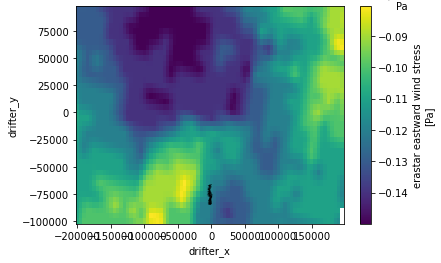

In [12]:
ds_lim.es_box_matchup_tauu.plot(x='box_x', y='box_y')
ds_lim.plot.quiver(x='drifter_x',y='drifter_y', u='es_traj_tauu', v='es_traj_tauv')

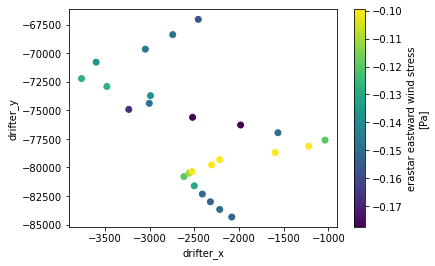

In [15]:
ds_lim.plot.scatter(x='drifter_x',y='drifter_y', hue='es_traj_tauu')

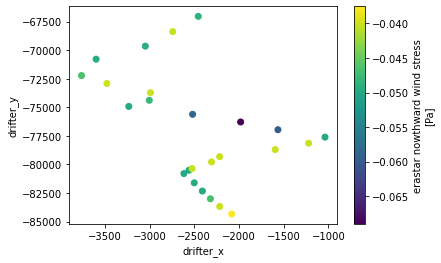

In [16]:
ds_lim.plot.scatter(x='drifter_x',y='drifter_y', hue='es_traj_tauv')

In [6]:
ds_concat = eras._concat_eras(ds_data.isel(obs=slice(0,10)), dt=(-1,1), only_matchup_time=True).persist()

In [7]:
ds_concat.isel(obs=0).es_traj_tauu.compute()

<xarray.DataArray 'es_traj_tauu' (site_obs: 1489)>
array([nan, nan, nan, ..., nan, nan, nan])
Dimensions without coordinates: site_obs
Attributes:
    standard_name:  surface_downward_eastward_stress
    long_name:      erastar eastward wind stress
    units:          Pa

test
1 load t =< 0.5s
1 obs load pour 25 t =< 1/4 min environ  -> temps = 1/4 *taillechunkobs * nbchunk/nbprocess = 1/4 * totalobs/nbprocess
job=1, cores=5, processes=5, chunks=100, slice(0,500) -> 14h04-14h31 pas fini
job=1, cores=10, processes=10, chunks=25, slice(0,500) -> 14h45-14h55 

In [10]:
ds_es = eras.compute_eras(ds_data.isel(obs=slice(7000,7500)), dt=(-12,13), only_matchup_time = True).persist()

In [5]:
ds_es.sel({})

<xarray.Dataset>
Dimensions:                  (box_x: 80, box_y: 40, obs: 500, site_obs: 1489,
                              es_time: 25)
Coordinates:
  * box_x                    (box_x) float64 -2e+05 -1.95e+05 ... 1.95e+05
  * box_y                    (box_y) float64 -1e+05 -9.5e+04 ... 9e+04 9.5e+04
    es_time_                 (obs, es_time) datetime64[ns] dask.array<chunksize=(25, 25), meta=np.ndarray>
    time                     (obs) datetime64[ns] dask.array<chunksize=(25,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs, es_time
Data variables: (12/19)
    traj_es_tauu             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    traj_es_tauv             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    traj_e5_tauu             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    traj_e5_tauv             (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    drifter_time             (obs, site_obs) datetime64[ns] dask.array<chunksize=(25, 1489), meta=np.ndarray>
    drifter_x                (obs, site_obs) float64 dask.array<chunksize=(25, 1489), meta=np.ndarray>
    ...                       ...
    drifter_matchup_e5_tauu  (obs, es_time) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    drifter_matchup_e5_tauv  (obs, es_time) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    alti_matchup_es_tauu     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
    alti_matchup_es_tauv     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
    alti_matchup_e5_tauu     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
    alti_matchup_e5_tauv     (obs) float64 dask.array<chunksize=(25,), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                 CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:        Climate and Forecast (CF) 1.7, Attribute Con...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    title:                       hourly stress equivalent model wind componen...
    summary:                     This data set contains the stress equivalent...
    id:                          WOC-L4-SE-ERAstar-H
    ...                          ...
    platform:                    Metop-A, Metop-B
    platform_type:               low earth orbit satellite, low earth orbit s...
    instrument:                  ASCAT, ASCAT
    instrument_type:             scatterometer, scatterometer
    band:                        C, C
    format_version:              WOС v1.0

In [12]:
ds_es.isel(obs=0).es_traj_tauu.compute()

<xarray.DataArray 'es_traj_tauu' (site_obs: 1489)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
    time     datetime64[ns] 2018-06-11T10:00:00
Dimensions without coordinates: site_obs
Attributes:
    standard_name:  surface_downward_eastward_stress
    long_name:      erastar eastward wind stress
    units:          Pa

In [13]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
